# Chattea Intent Classifier - GPU Training Pipeline

Enhanced neural network with attention mechanism for bilingual (EN/ID) intent classification.

In [2]:
import torch
print(torch.version.cuda)            # should show 12.4 or 12.6
print(torch.cuda.is_available())     # should be True
print(torch.cuda.get_device_name(0)) # should show "NVIDIA GeForce RTX 4060"

13.0
True
NVIDIA GeForce RTX 4060 Laptop GPU


## 1. Setup & Configuration

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from tqdm import tqdm

In [4]:
class Config:
    DATA_PATH = 'chattea.csv'
    MODEL_SAVE_PATH = 'chattea_model_gpu.pth'
    RESPONSES_PATH = 'responses.json'
    EMBEDDING_DIM = 256
    HIDDEN_DIM = 512
    MAX_SEQ_LEN = 40
    DROPOUT = 0.3
    BATCH_SIZE = 64
    EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-5
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    RANDOM_STATE = 42
    MIN_FREQ = 1
    CONFIDENCE_THRESHOLD = 0.65

print(f"🚀 Using device: {Config.DEVICE}")

🚀 Using device: cuda


## 2. Preprocessing

In [5]:
class IntentPreprocessor:
    def __init__(self, max_len=Config.MAX_SEQ_LEN):
        self.max_len = max_len
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        self.word2idx = self.vocab.copy()
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.vocab_size = 2
        
    def tokenize(self, text):
        if not isinstance(text, str):
            return []
        text = text.lower()
        text = re.sub(r"[^a-z0-9\s']", ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text.split()
    
    def build_vocab(self, texts, min_freq=Config.MIN_FREQ):
        word_freq = Counter()
        for text in tqdm(texts, desc="Building vocab"):
            word_freq.update(self.tokenize(text))
        
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        self.vocab_size = len(self.word2idx)
        print(f"Vocab size: {self.vocab_size}")
        return self
    
    def encode(self, text):
        tokens = self.tokenize(text)
        indices = [self.word2idx.get(t, 1) for t in tokens]
        if len(indices) < self.max_len:
            indices += [0] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return indices
    
    def encode_batch(self, texts):
        return [self.encode(text) for text in texts]

## 3. Model

In [6]:
class EnhancedAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.num_heads = 2
        head_dim = embedding_dim // self.num_heads
        
        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)
        self.attention_scale = np.sqrt(head_dim)
        
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, num_classes)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)
        
        Q = self.query(embedded).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        K = self.key(embedded).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        V = self.value(embedded).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.attention_scale
        mask = (x == 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(mask, -1e9)
        weights = torch.softmax(scores, dim=-1)
        attended = torch.matmul(weights, V)
        attended = attended.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        attended = self.layer_norm1(attended + embedded)
        
        mask = (x != 0).unsqueeze(-1).float()
        pooled = (attended * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        
        x = self.relu(self.fc1(pooled))
        x = self.layer_norm2(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        return self.fc4(x)

## 4. Dataset

In [7]:
class IntentDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.encoded = preprocessor.encode_batch(texts)
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encoded[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

## 5. Trainer

In [8]:
class GPUTrainer:
    def __init__(self, model, device=Config.DEVICE):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.best_val_acc = 0
    
    def train_epoch(self, loader, optimizer, criterion):
        self.model.train()
        total_loss = 0
        for batch in tqdm(loader, desc="Training", leave=False):
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['label'].to(self.device)
            optimizer.zero_grad()
            logits = self.model(input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)
    
    def validate(self, loader, criterion):
        self.model.eval()
        total_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in tqdm(loader, desc="Validating", leave=False):
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['label'].to(self.device)
                logits = self.model(input_ids)
                loss = criterion(logits, labels)
                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        return total_loss / len(loader), accuracy_score(all_labels, all_preds), all_preds, all_labels
    
    def train(self, train_loader, val_loader, epochs=Config.EPOCHS, lr=Config.LEARNING_RATE):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=Config.WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        
        patience, patience_counter = 10, 0
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            train_loss = self.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc, _, _ = self.validate(val_loader, criterion)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            scheduler.step(val_acc)
            
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save({'model_state_dict': self.model.state_dict(), 'val_acc': val_acc}, Config.MODEL_SAVE_PATH)
                print(f"✓ Best model saved! (Acc: {val_acc:.4f})")
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
        
        checkpoint = torch.load(Config.MODEL_SAVE_PATH)
        self.model.load_state_dict(checkpoint['model_state_dict'])
    
    def plot_training(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Train')
        ax1.plot(epochs, self.val_losses, 'r-', label='Val')
        ax1.set_title('Loss')
        ax1.legend()
        ax2.plot(epochs, self.val_accuracies, 'g-')
        ax2.set_title('Validation Accuracy')
        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300)
        plt.show()
    
    def evaluate(self, loader, intent_names):
        criterion = nn.CrossEntropyLoss()
        _, acc, preds, labels = self.validate(loader, criterion)
        print(f"\nAccuracy: {acc:.4f}")
        print(classification_report(labels, preds, target_names=intent_names))

## 6. Chatbot

In [9]:
class ChatteaBot:
    def __init__(self, model, preprocessor, intent_map, responses, threshold=Config.CONFIDENCE_THRESHOLD, device=Config.DEVICE):
        self.model = model.to(device).eval()
        self.preprocessor = preprocessor
        self.intent_map = intent_map
        self.responses = responses
        self.threshold = threshold
        self.device = device
    
    def detect_language(self, text):
        indo_words = ['bagaimana', 'cara', 'saya', 'apa', 'yang', 'untuk']
        return 'id' if any(w in text.lower() for w in indo_words) else 'en'
    
    def predict(self, text):
        lang = self.detect_language(text)
        encoded = torch.tensor([self.preprocessor.encode(text)], dtype=torch.long).to(self.device)
        
        with torch.no_grad():
            logits = self.model(encoded)
            probs = torch.softmax(logits, dim=1)
            conf, pred_idx = torch.max(probs, dim=1)
        
        intent = self.intent_map[pred_idx.item()]
        conf_val = conf.item()
        
        response_dict = self.responses.get(intent, self.responses.get('out_of_scope'))
        if isinstance(response_dict, dict):
            response = response_dict.get(lang, response_dict.get('en', 'No response'))
        else:
            response = response_dict
        
        if conf_val < self.threshold:
            fallback = self.responses.get('out_of_scope')
            response = fallback.get(lang, fallback.get('en')) if isinstance(fallback, dict) else fallback
            intent = 'out_of_scope'
        
        return {'intent': intent, 'confidence': conf_val, 'language': lang, 'response': response}
    
    def chat(self):
        print("\nChattea Bot (type 'exit' to quit)\n")
        while True:
            user_input = input("You: ").strip()
            if user_input.lower() in ['exit', 'quit']:
                print("Bot: Goodbye!")
                break
            if not user_input:
                continue
            result = self.predict(user_input)
            print(f"Bot: {result['response']}")
            print(f"     [Intent: {result['intent']}, Confidence: {result['confidence']:.3f}]\n")

## 7. Main Execution

In [10]:
# Load data
print("Loading dataset...")
df = pd.read_csv(Config.DATA_PATH)
print(f"Total samples: {len(df)}")
print(f"Unique intents: {df['intent'].nunique()}")

# Prepare data
texts = df['text'].tolist()
intents = df['intent'].tolist()
unique_intents = sorted(df['intent'].unique())
intent_to_idx = {intent: idx for idx, intent in enumerate(unique_intents)}
idx_to_intent = {idx: intent for intent, idx in intent_to_idx.items()}
labels = [intent_to_idx[intent] for intent in intents]

Loading dataset...
Total samples: 4959
Unique intents: 85


In [11]:
# Split data
X_temp, X_test, y_temp, y_test = train_test_split(texts, labels, test_size=Config.TEST_SIZE, random_state=Config.RANDOM_STATE, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=Config.VAL_SIZE/(1-Config.TEST_SIZE), random_state=Config.RANDOM_STATE, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 3471, Val: 744, Test: 744


In [12]:
# Build preprocessor
preprocessor = IntentPreprocessor()
preprocessor.build_vocab(X_train)

Building vocab: 100%|██████████| 3471/3471 [00:00<00:00, 241281.27it/s]

Vocab size: 1024


In [13]:
# Create datasets
train_dataset = IntentDataset(X_train, y_train, preprocessor)
val_dataset = IntentDataset(X_val, y_val, preprocessor)
test_dataset = IntentDataset(X_test, y_test, preprocessor)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

In [14]:
# Initialize model
model = EnhancedAttentionClassifier(
    vocab_size=preprocessor.vocab_size,
    embedding_dim=Config.EMBEDDING_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    num_classes=len(unique_intents),
    dropout=Config.DROPOUT
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 767,829


In [15]:
# Train
trainer = GPUTrainer(model)
trainer.train(train_loader, val_loader)


Epoch 1/50


Train Loss: 4.2584 | Val Loss: 3.1934 | Val Acc: 0.4220
✓ Best model saved! (Acc: 0.4220)

Epoch 2/50


Train Loss: 2.5315 | Val Loss: 1.2520 | Val Acc: 0.7030
✓ Best model saved! (Acc: 0.7030)

Epoch 3/50


Train Loss: 1.3162 | Val Loss: 0.6676 | Val Acc: 0.8185
✓ Best model saved! (Acc: 0.8185)

Epoch 4/50


Train Loss: 0.7553 | Val Loss: 0.4950 | Val Acc: 0.8629
✓ Best model saved! (Acc: 0.8629)

Epoch 5/50


Train Loss: 0.4882 | Val Loss: 0.4621 | Val Acc: 0.8844
✓ Best model saved! (Acc: 0.8844)

Epoch 6/50


Train Loss: 0.3361 | Val Loss: 0.4202 | Val Acc: 0.9059
✓ Best model saved! (Acc: 0.9059)

Epoch 7/50


Train Loss: 0.2426 | Val Loss: 0.4486 | Val Acc: 0.9046

Epoch 8/50


Train Loss: 0.2094 | Val Loss: 0.5109 | Val Acc: 0.9140
✓ Best model saved! (Acc: 0.9140)

Epoch 9/50


Train Loss: 0.1565 | Val Loss: 0.5258 | Val Acc: 0.9167
✓ Best model saved! (Acc: 0.9167)

Epoch 10/50


Train Loss: 0.1523 | Val Loss: 0.5519 | Val Acc: 0.9126

Epoch 11/50


Train Loss: 0.1242 | Val Loss: 0.5108 | Val Acc: 0.9140

Epoch 12/50


Train Loss: 0.1167 | Val Loss: 0.5734 | Val Acc: 0.9113

Epoch 13/50


Train Loss: 0.0956 | Val Loss: 0.7046 | Val Acc: 0.9140

Epoch 14/50


Train Loss: 0.1147 | Val Loss: 0.6658 | Val Acc: 0.9194
✓ Best model saved! (Acc: 0.9194)

Epoch 15/50


Train Loss: 0.0953 | Val Loss: 0.5883 | Val Acc: 0.9180

Epoch 16/50


Train Loss: 0.0878 | Val Loss: 0.6403 | Val Acc: 0.9180

Epoch 17/50


Train Loss: 0.0834 | Val Loss: 0.5647 | Val Acc: 0.9247
✓ Best model saved! (Acc: 0.9247)

Epoch 18/50


Train Loss: 0.0759 | Val Loss: 0.6654 | Val Acc: 0.9167

Epoch 19/50


Train Loss: 0.0676 | Val Loss: 0.6272 | Val Acc: 0.9315
✓ Best model saved! (Acc: 0.9315)

Epoch 20/50


Train Loss: 0.0582 | Val Loss: 0.6720 | Val Acc: 0.9301

Epoch 21/50


Train Loss: 0.0574 | Val Loss: 0.7029 | Val Acc: 0.9113

Epoch 22/50


Train Loss: 0.0606 | Val Loss: 0.7854 | Val Acc: 0.9153

Epoch 23/50


Train Loss: 0.0495 | Val Loss: 0.6141 | Val Acc: 0.9207

Epoch 24/50


Train Loss: 0.0566 | Val Loss: 0.6018 | Val Acc: 0.9341
✓ Best model saved! (Acc: 0.9341)

Epoch 25/50


Train Loss: 0.0619 | Val Loss: 0.5950 | Val Acc: 0.9220

Epoch 26/50


Train Loss: 0.0402 | Val Loss: 0.6279 | Val Acc: 0.9328

Epoch 27/50


Train Loss: 0.0461 | Val Loss: 0.6533 | Val Acc: 0.9328

Epoch 28/50


Train Loss: 0.0492 | Val Loss: 0.6326 | Val Acc: 0.9341

Epoch 29/50


Train Loss: 0.0426 | Val Loss: 0.6664 | Val Acc: 0.9234

Epoch 30/50


Train Loss: 0.0441 | Val Loss: 0.7010 | Val Acc: 0.9274

Epoch 31/50


Train Loss: 0.0390 | Val Loss: 0.6792 | Val Acc: 0.9301

Epoch 32/50


Train Loss: 0.0308 | Val Loss: 0.6942 | Val Acc: 0.9288

Epoch 33/50


Train Loss: 0.0177 | Val Loss: 0.6785 | Val Acc: 0.9301

Epoch 34/50


Train Loss: 0.0171 | Val Loss: 0.6919 | Val Acc: 0.9288
Early stopping triggered


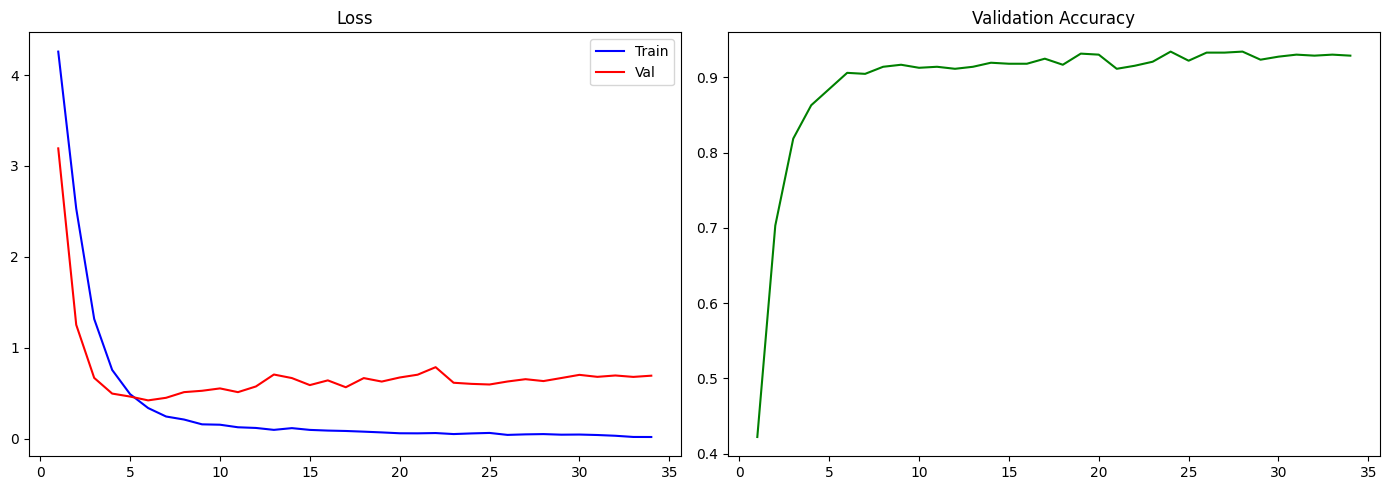

In [16]:
# Plot training curves
trainer.plot_training()

In [17]:
# Evaluate
trainer.evaluate(test_loader, unique_intents)


Accuracy: 0.9409
                               precision    recall  f1-score   support

                account_setup       0.80      0.89      0.84         9
advanced_contact_segmentation       1.00      1.00      1.00         9
               analytics_view       1.00      1.00      1.00         9
                api_reference       1.00      1.00      1.00         9
             api_send_message       1.00      1.00      1.00         5
            api_webhook_setup       1.00      1.00      1.00         9
           auto_reply_disable       0.90      1.00      0.95         9
             auto_reply_setup       1.00      1.00      1.00         9
         calendar_integration       1.00      1.00      1.00         9
                cancel_action       1.00      0.57      0.73         7
                 chat_history       0.90      1.00      0.95         9
                    chat_read       1.00      1.00      1.00         4
                    chat_send       0.90      1.00      0.

In [18]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'preprocessor': preprocessor,
    'intent_map': idx_to_intent,
    'config': {
        'vocab_size': preprocessor.vocab_size,
        'embedding_dim': Config.EMBEDDING_DIM,
        'hidden_dim': Config.HIDDEN_DIM,
        'num_classes': len(unique_intents)
    }
}, 'chattea_complete_model.pth')
print("Model saved!")

Model saved!


## 8. Testing

In [19]:
# Load/create responses
if os.path.exists(Config.RESPONSES_PATH):
    with open(Config.RESPONSES_PATH, 'r', encoding='utf-8') as f:
        responses = json.load(f)
else:
    responses = {intent: f"Response for {intent}" for intent in unique_intents}
    responses['out_of_scope'] = "Sorry, I don't understand."
    with open(Config.RESPONSES_PATH, 'w', encoding='utf-8') as f:
        json.dump(responses, f, ensure_ascii=False, indent=2)

In [20]:
# Initialize bot
bot = ChatteaBot(model, preprocessor, idx_to_intent, responses)

# Test predictions
test_queries = [
    "How do I create an account?",
    "Bagaimana cara membuat akun?",
    "Send bulk messages"
]

for query in test_queries:
    result = bot.predict(query)
    print(f"\nQuery: {query}")
    print(f"Intent: {result['intent']} ({result['confidence']:.3f})")
    print(f"Response: {result['response'][:100]}")


Query: How do I create an account?
Intent: account_setup (1.000)
Response: To create a Chattea account:
1. Visit chattea.com or open the app
2. Click 'Register' or 'Sign Up'
3

Query: Bagaimana cara membuat akun?
Intent: account_setup (1.000)
Response: Untuk membuat akun Chattea:
1. Kunjungi chattea.com atau buka aplikasi
2. Klik 'Daftar' atau 'Sign U

Query: Send bulk messages
Intent: message_blast (1.000)
Response: To send a mass (blast) message:
1. 'Blast Message' tab → 'New Blast'
2. Choose target contacts/group
